In [1]:
suppressPackageStartupMessages({
    source("../code/process_slim_vcf.R")
    library(ggbeeswarm)
    library(tidyverse)
    library(magrittr)
    library("future")
    plan(multicore)
})

In [2]:
region <- "protein_coding"
reps <- 10
gens <- c(seq(10), 20, 50, seq(100, 1000, 100), seq(1200, 2200, 200))

In [3]:
# read all Nea/MH deleterious mutations and neutral markers over time
raw_nea_muts <- raw_mh_muts <- raw_region_markers <- raw_gap_markers <- NULL

for (rep_i in seq_len(reps)) {

for (gen in gens) {
    vcf <- readVcf(paste0("../data/simulations/delta_constant_", region, "_h_0.5_rep_", rep_i, "_gen_", gen, ".vcf.gz"))

    raw_region_markers %<>% bind_rows(get_markers(vcf, paste0("../data/slim_coords/", region, "_all_sites.bed"), within_region="region", fill_freq=FALSE) %>% .[c("MID", "S", "freq")] %>% mutate(gen=gen, rep=rep_i, MID=paste0(rep, "_", MID))) %>% bind_rows
    raw_gap_markers %<>% bind_rows(get_markers(vcf, paste0("../data/slim_coords/", region, "_all_sites.bed"), within_region="gap", fill_freq=FALSE) %>% .[c("MID", "S", "freq")] %>% mutate(gen=gen, rep=rep_i, MID=paste0(rep, "_", MID))) %>% bind_rows    

    raw_mh_muts %<>% bind_rows(mut_info(vcf, mut_type=0, pop_origin=1, t_min=70000) %>% as.data.frame %>% .[c("MID", "S", "freq")] %>% mutate(gen=gen, rep=rep_i, MID=paste0(rep, "_", MID))) %>% bind_rows
    raw_nea_muts %<>% bind_rows(mut_info(vcf, mut_type=0, pop_origin=2, t_min=70000) %>% as.data.frame %>% .[c("MID", "S", "freq")] %>% mutate(gen=gen, rep=rep_i, MID=paste0(rep, "_", MID))) %>% bind_rows
}

}

In [4]:
# fix this to that freqs are added only to the very end of the data.frame
complete_mut <- function(df) {
    # we want to know the frequency of a mutation at least in first X generations
    # (otherwise just kick out the mutation completelu)
    minimum_gen <- gens[1:10]
    if (length(intersect(df$gen, minimum_gen)) != length(minimum_gen)) return(NULL)

    # we have an information about the freq in the very last generation already
    if (df[nrow(df), "gen"] == gens[length(gens)]) return(df)

    empty_gen <- data.frame(gen=gens[(which(gens == max(df$gen)) + 1) : length(gens)])
    bind_rows(df[c("freq", "gen")], empty_gen) %>% 
        replace_na(list(freq=0)) %>%
        mutate(MID=df$MID[1], S=df$S[1], rep=df$rep[1]) %>%
        .[c("MID", "S", "freq", "gen", "rep")]
}

### Complete the mutation dataframes for mutations that get lost

In [5]:
nea_muts %<-% { raw_nea_muts %>% split(., .[["MID"]]) %>% lapply(complete_mut) %>% compact %>% bind_rows %>% mutate(mut_type="Nea_del") %>% as_tibble }

In [6]:
mh_muts %<-% { raw_mh_muts %>% split(., .[["MID"]]) %>% lapply(complete_mut) %>% compact %>% bind_rows %>% mutate(mut_type="MH_del") %>% as_tibble }

In [7]:
gap_markers %<-% { raw_gap_markers %>% split(., .[["MID"]]) %>% lapply(complete_mut) %>% compact %>% bind_rows %>% mutate(mut_type="gap_marker") %>% as_tibble }

In [8]:
region_markers %<-% { raw_region_markers %>% split(., .[["MID"]]) %>% lapply(complete_mut) %>% compact %>% bind_rows %>% mutate(mut_type="region_marker") %>% as_tibble }

### Trajectories of different mutation types

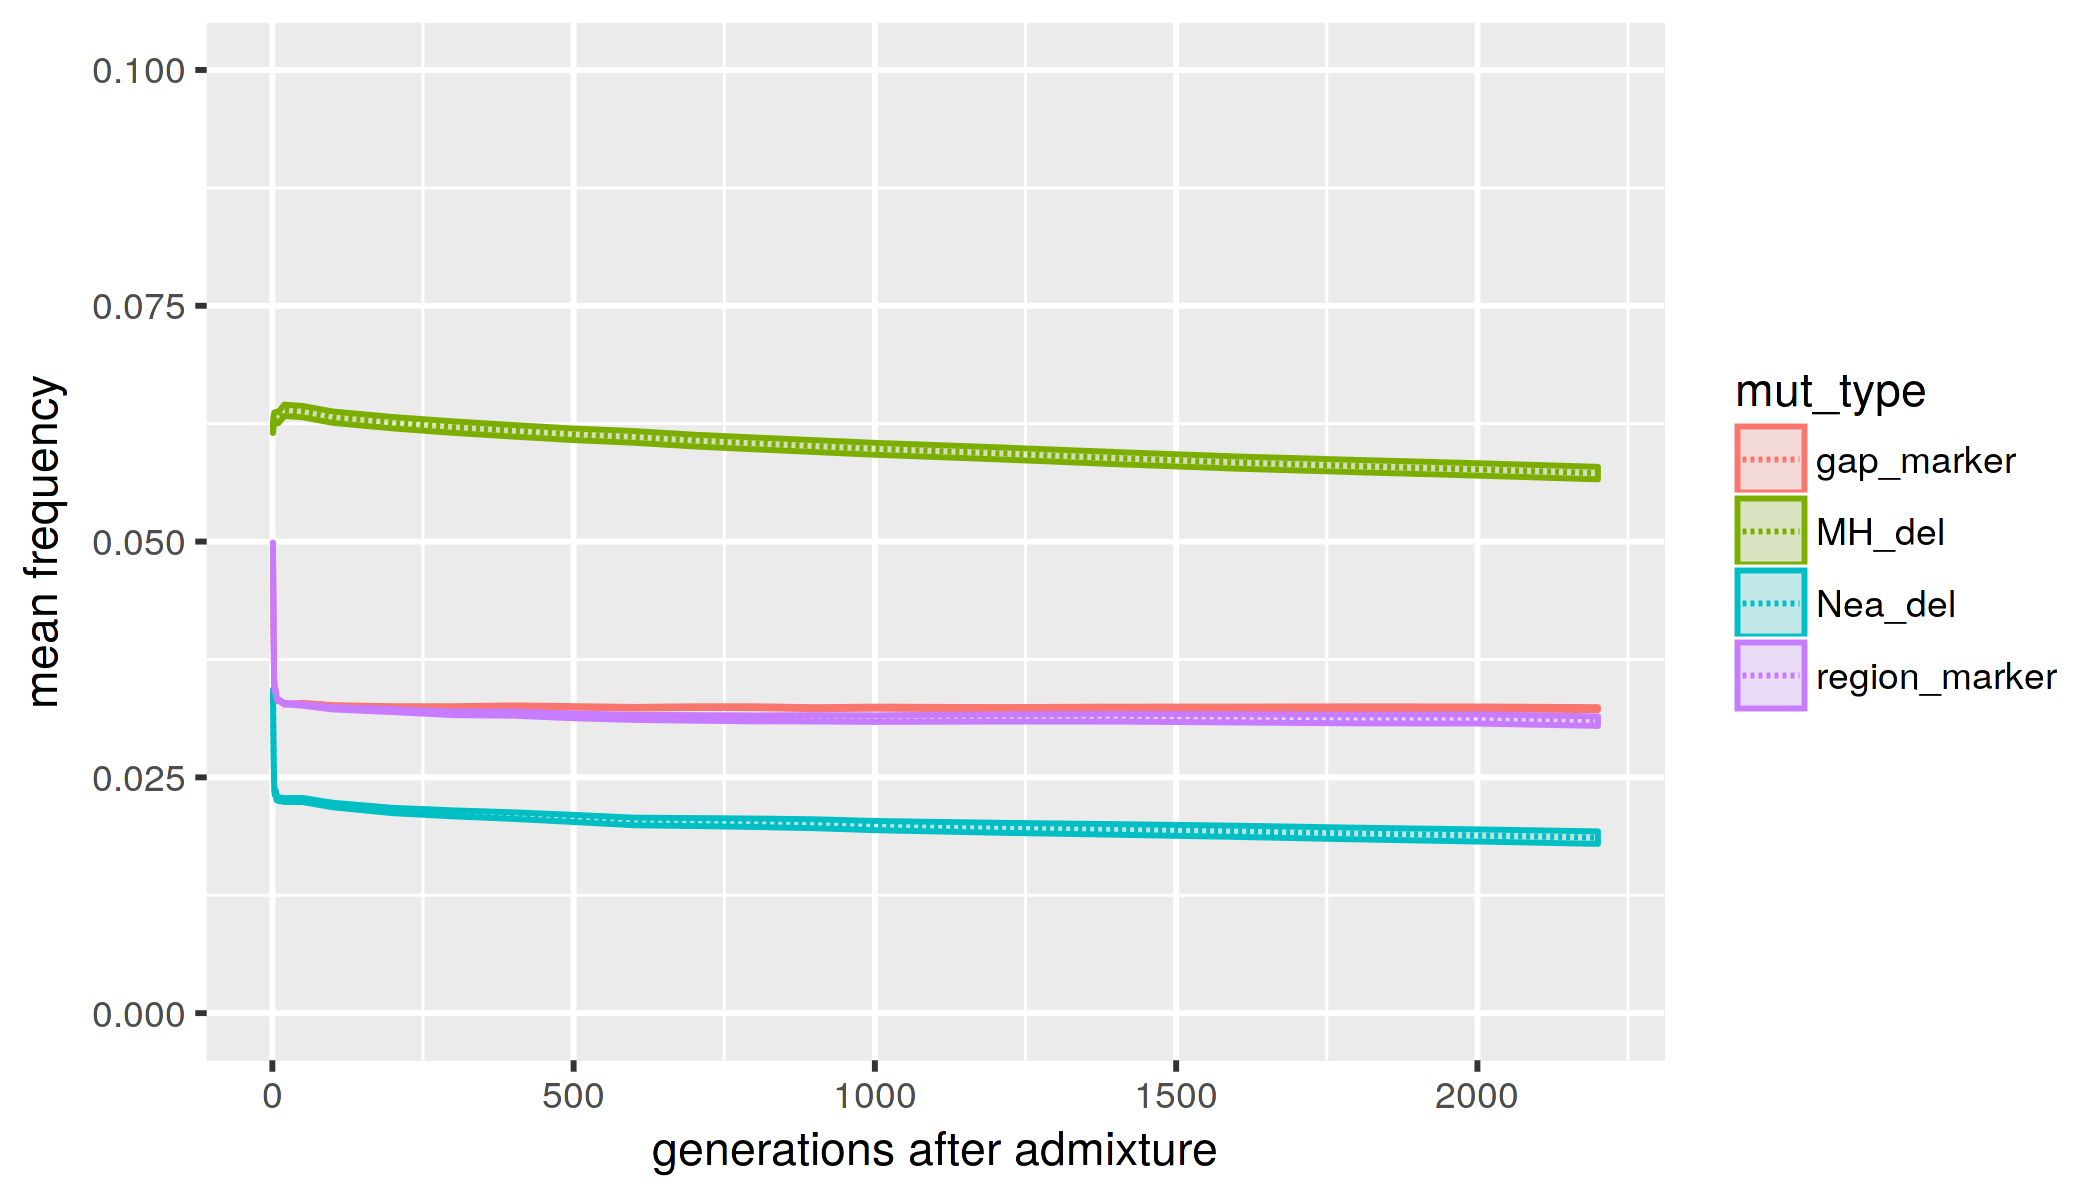

In [9]:
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res=300)

bind_rows(nea_muts, mh_muts, gap_markers, region_markers) %>%
    group_by(gen, mut_type) %>%
    summarise(avg_freq=mean(freq), sd_delta=sd(freq), n_delta=n()) %>%
    mutate(se_delta=sd_delta / sqrt(n_delta),
           lower_ci=avg_freq - qt(1 - (0.05 / 2), n_delta - 1) * se_delta,
           upper_ci=avg_freq + qt(1 - (0.05 / 2), n_delta - 1) * se_delta) %>% 
    ggplot(aes(gen, avg_freq, color=mut_type)) +
    geom_line(linetype=2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill=mut_type), alpha=1/5) +
    xlab("generations after admixture") + ylab("mean frequency") +
    coord_cartesian(y=c(0, 0.1)) #+ ggtitle("Mean frequencies of mutations of a given type")

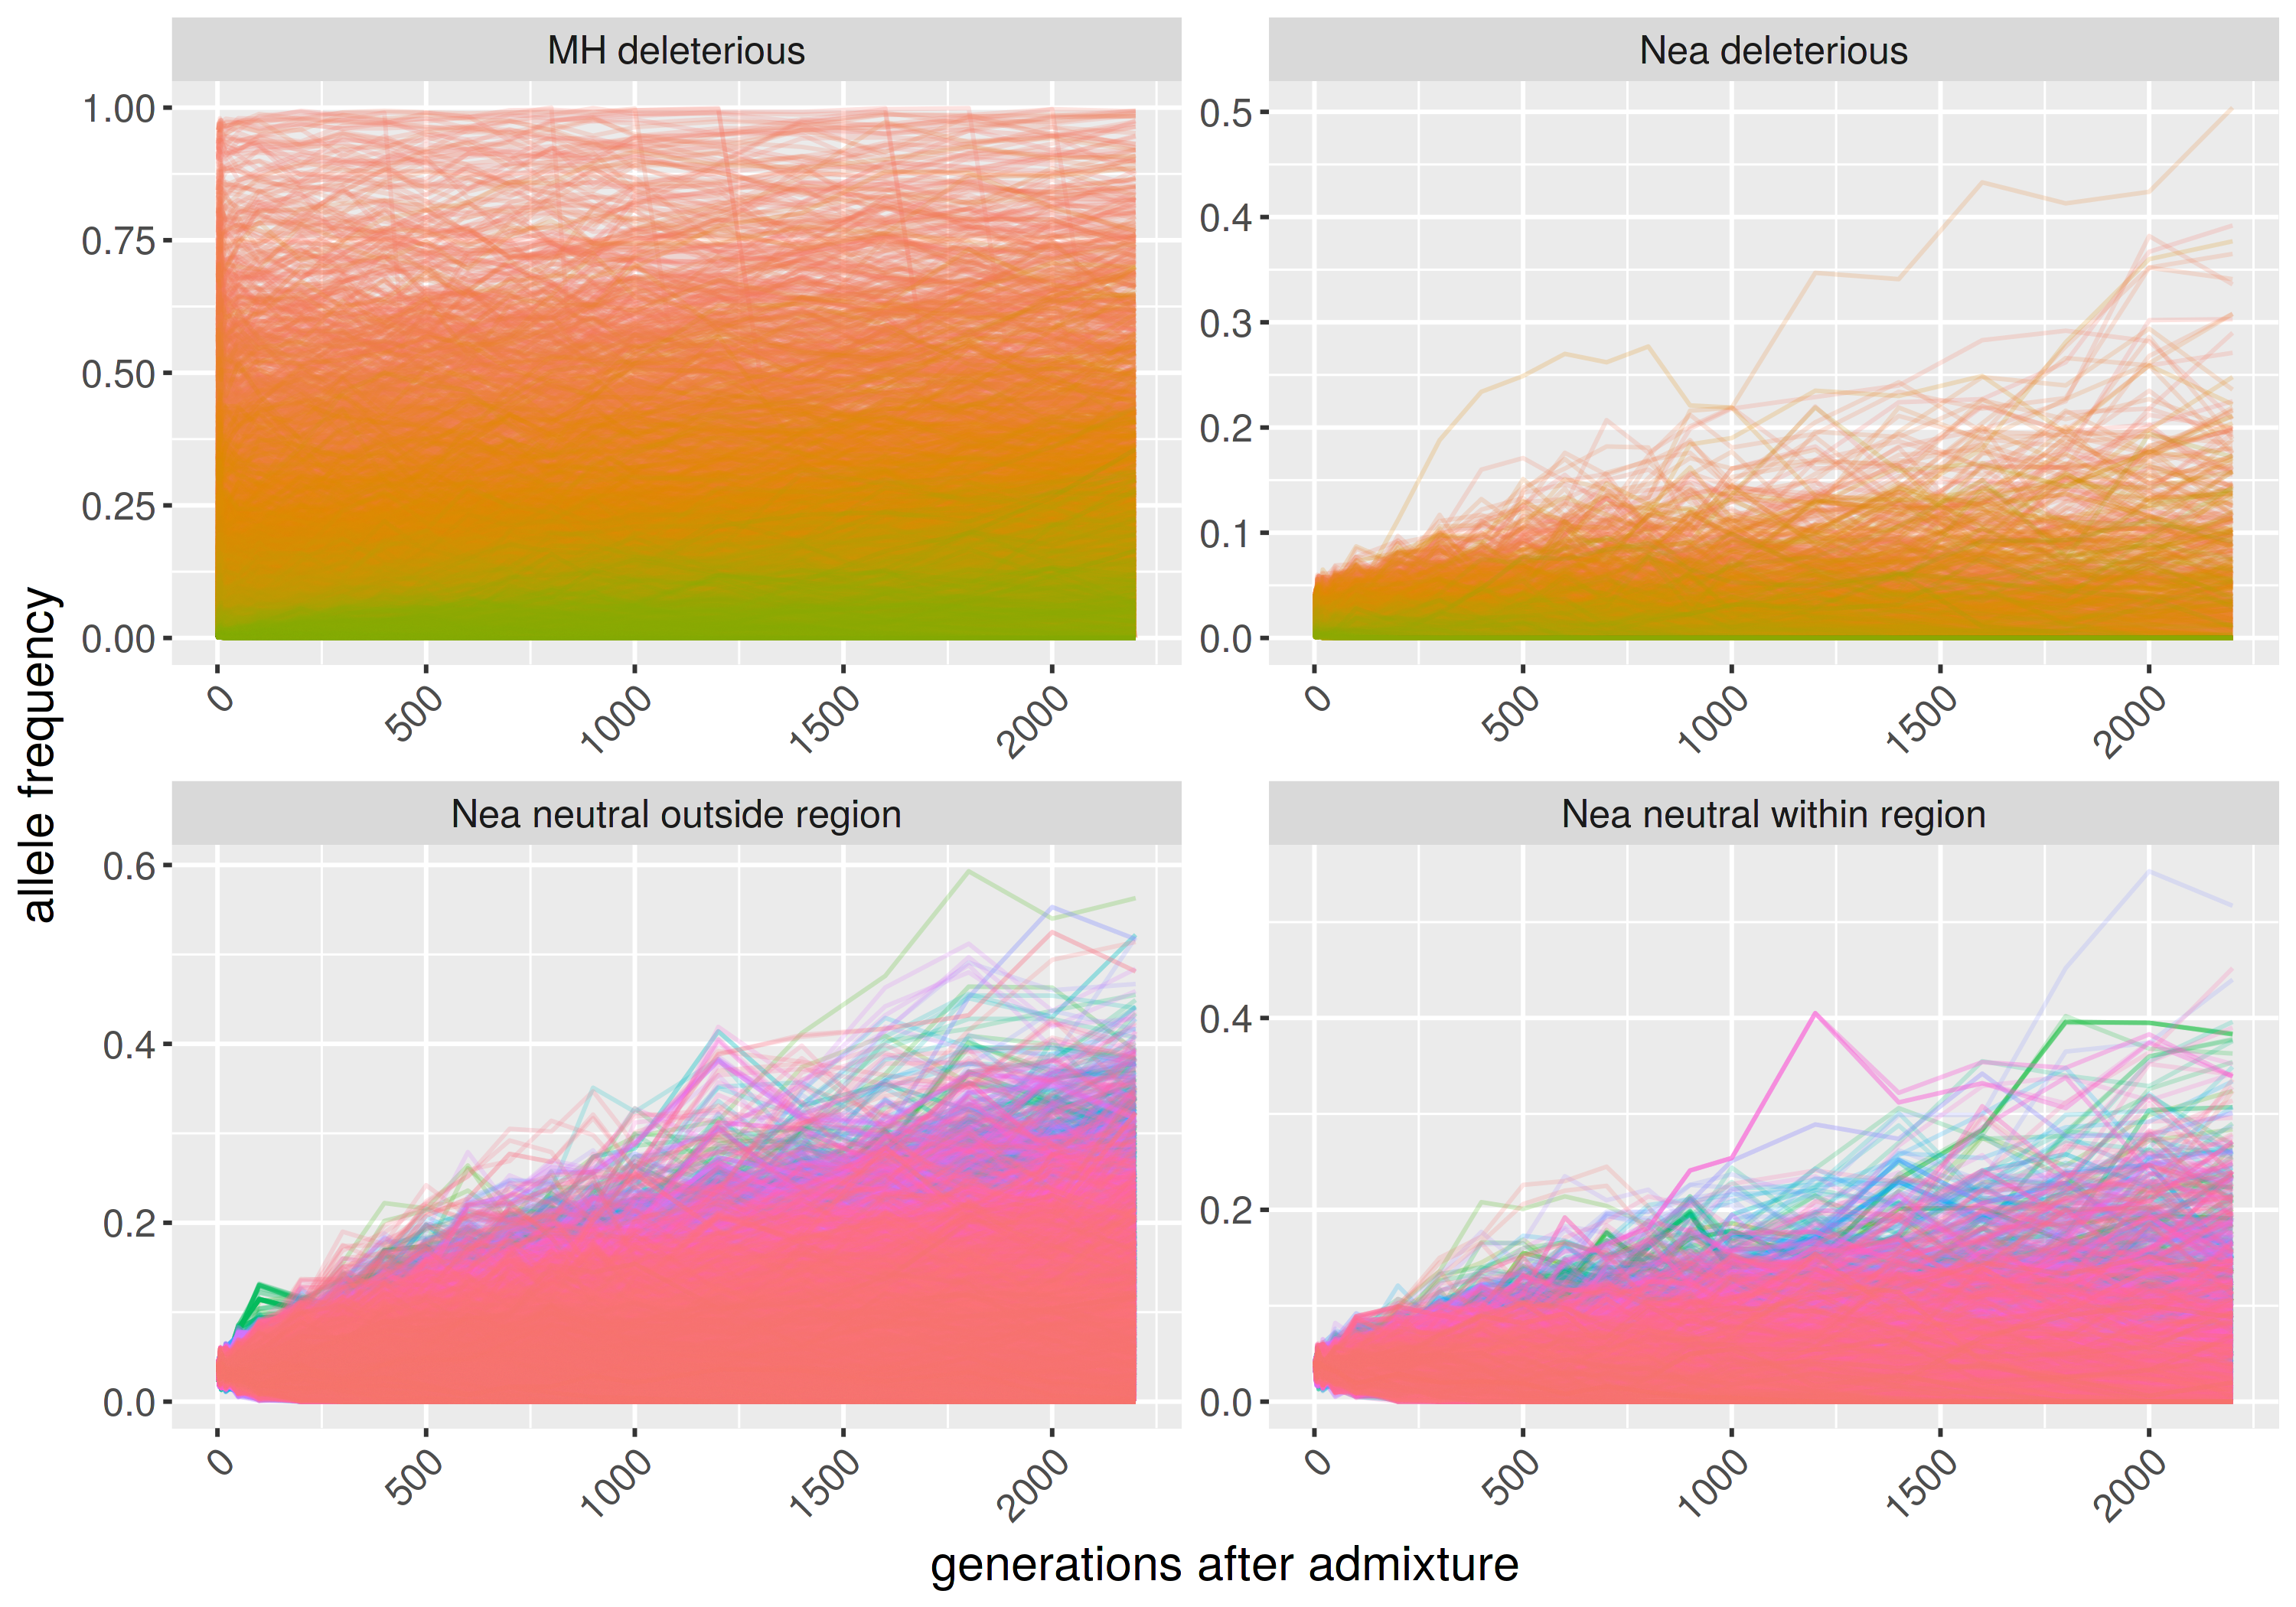

In [10]:
options(repr.plot.width=10, repr.plot.height=7, repr.plot.res=300)

bind_rows(nea_muts,mh_muts, gap_markers, region_markers) %>%
mutate(mut_type=factor(mut_type, levels=c("MH_del", "gap_marker", "Nea_del", "region_marker"))) %>% 
    filter(rep == 1) %>%
mutate(mut_type=str_replace(mut_type, "MH_del", "MH deleterious") %>%
                str_replace("Nea_del", "Nea deleterious") %>%
                str_replace("gap_marker", "Nea neutral outside region") %>% 
                str_replace("region_marker", "Nea neutral within region")) %>% 
    ggplot(aes(gen, freq, color=factor(MID))) + geom_line(alpha=1/5) +
        facet_wrap(~ mut_type, scales="free") +
        xlab("generations after admixture") + ylab("allele frequency") +
        theme(legend.position="none", text=element_text(size=15), axis.text.x = element_text(hjust=1, angle=45))
        #ggtitle("Allele frequencies of individual mutations over time")

### Calculate frequency deltas

In [11]:
calc_deltas <- function(df) {
    tibble(g=df$gen[2:nrow(df)],
           t=diff(df$gen),
           delta_f=diff(df$freq) / t,
           MID=df$MID[1],
           logS=log10(-df$S[1]),
           mut_type=df$mut_type[1])
}

Set future limit to 900 Mb:

In [12]:
options(future.globals.maxSize= 900*1024^2)

In [13]:
nea_deltas %<-% { nea_muts %>% split(., .[["MID"]]) %>% lapply(calc_deltas) %>% bind_rows }

In [14]:
mh_deltas %<-% { mh_muts %>% split(., .[["MID"]]) %>% lapply(calc_deltas) %>% bind_rows }

In [15]:
gap_deltas %<-% { gap_markers %>% split(., .[["MID"]]) %>% lapply(calc_deltas) %>% bind_rows }

In [16]:
region_deltas %<-% { region_markers %>% split(., .[["MID"]]) %>% lapply(calc_deltas) %>% bind_rows }

In [17]:
deltas <- bind_rows(
  mutate(nea_deltas, mut_type="Nea_del"),
  mutate(mh_deltas, mut_type="MH_del"),
  mutate(gap_deltas, mut_type="gap_marker"),
  mutate(region_deltas, mut_type="region_marker")
) %>%
    select(-t) %>%
    mutate(rep=str_replace(MID, "_[0-9]+$", "")) %>%
    mutate(mut_type=factor(mut_type, levels=c("MH_del", "Nea_del", "gap_marker", "region_marker")))

`geom_smooth()` using method = 'loess'


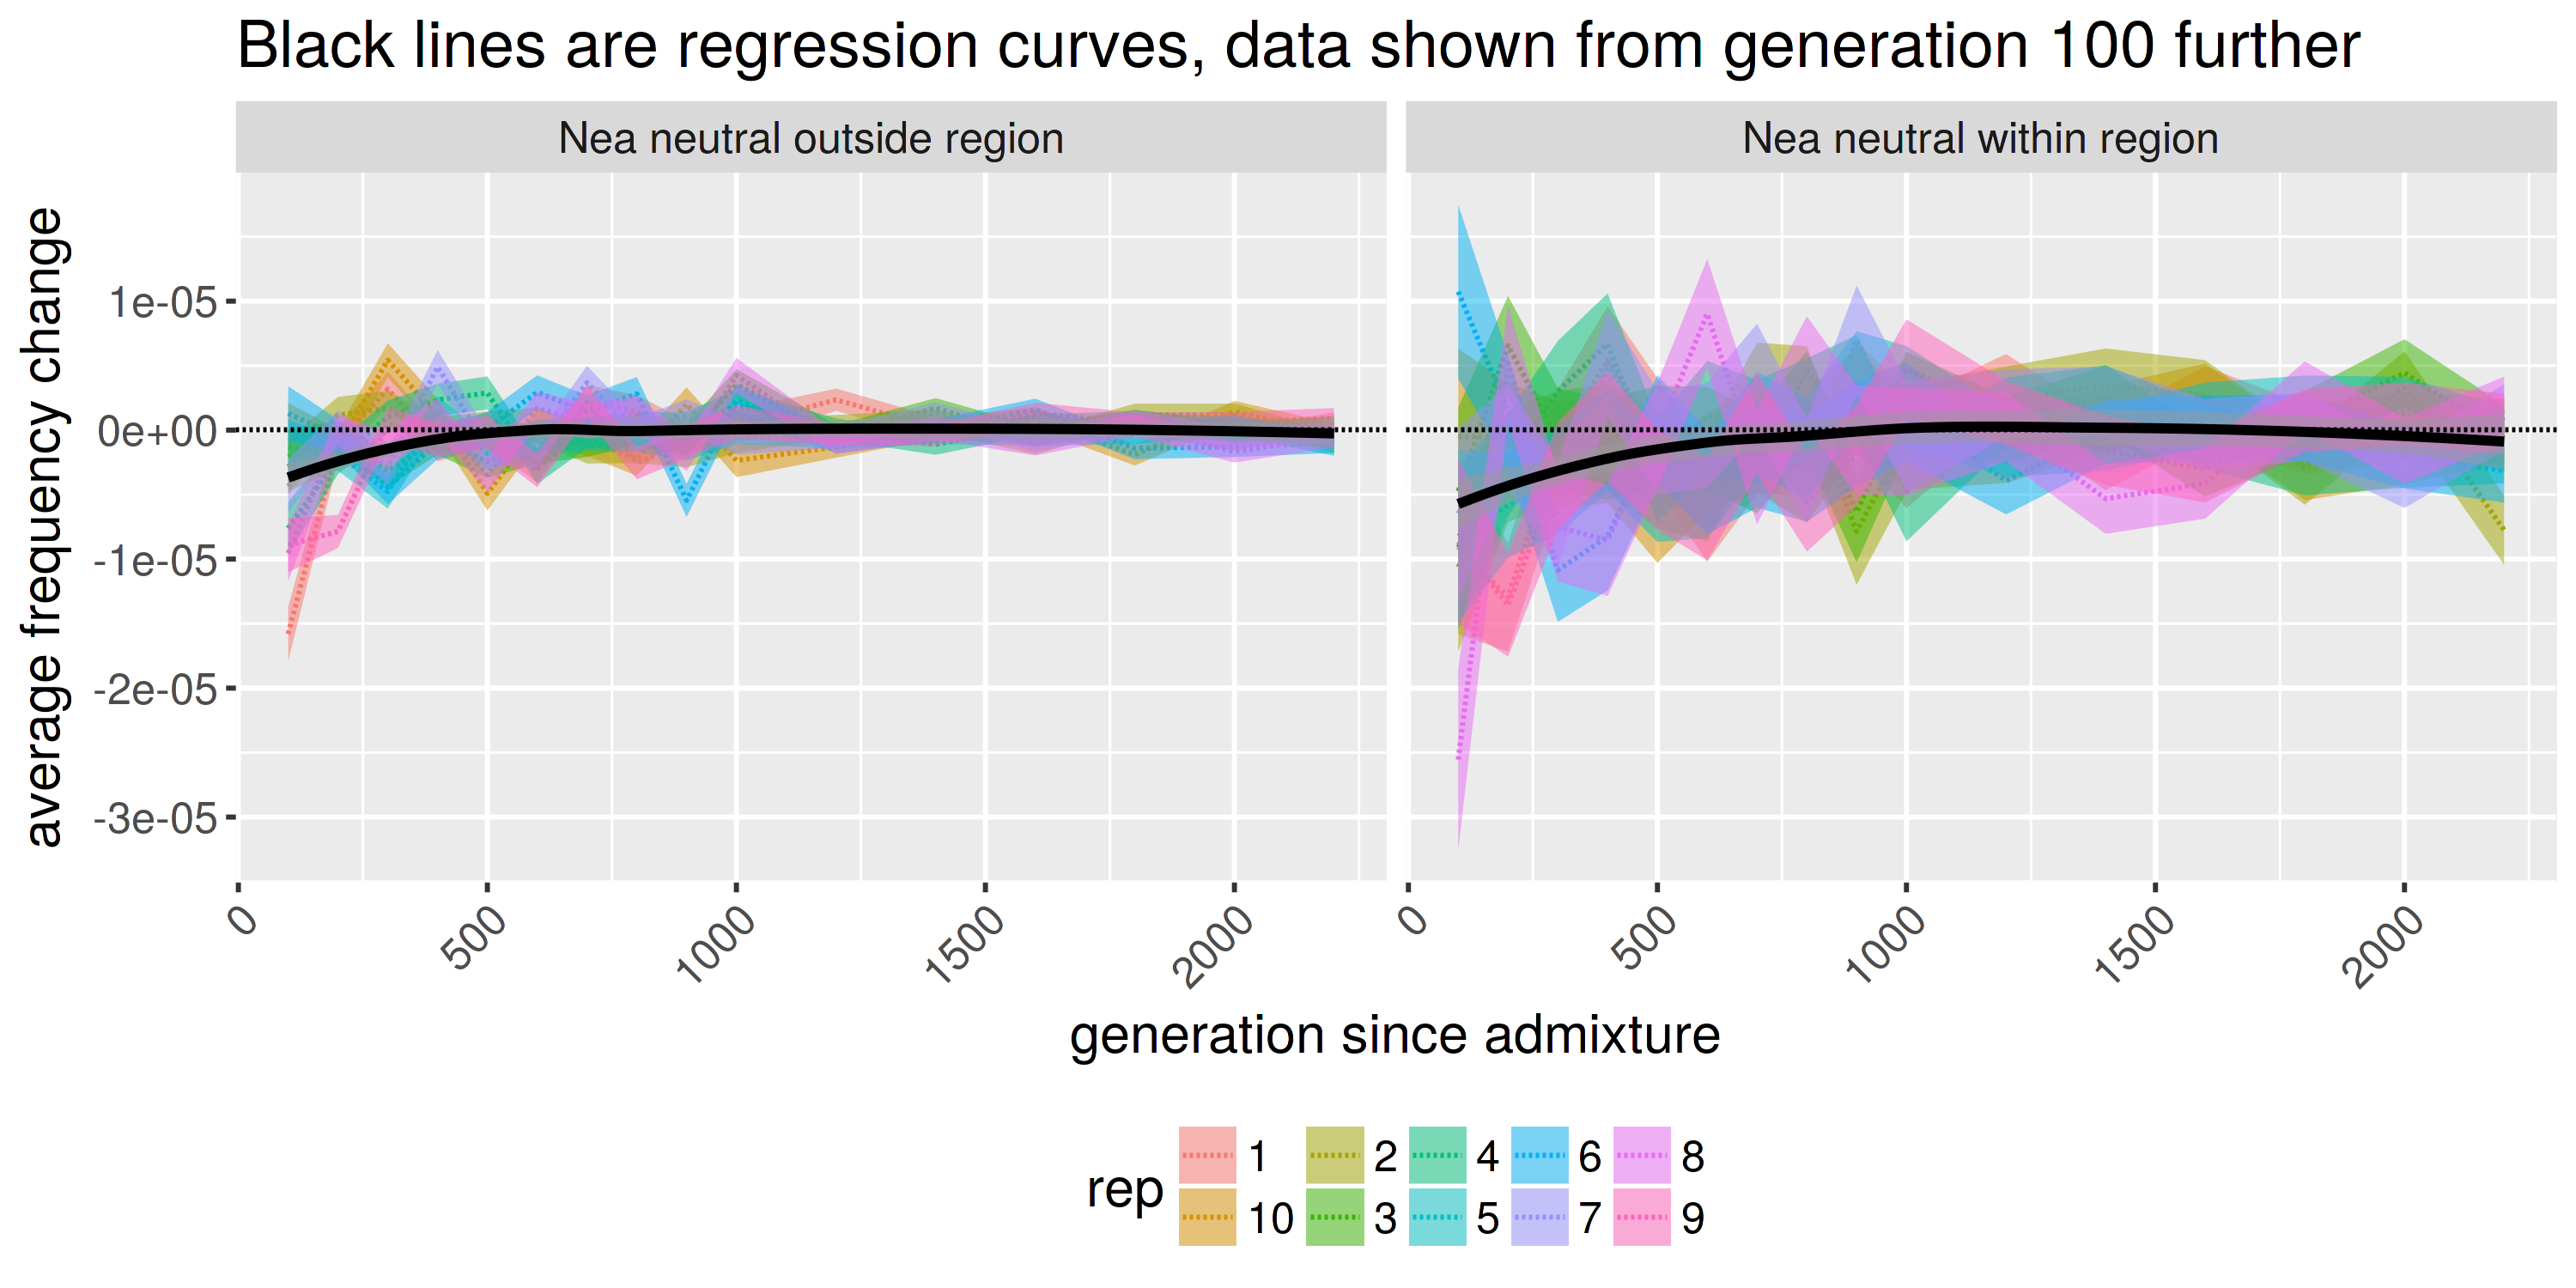

In [18]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

group_by(deltas, g, mut_type, rep) %>%    
    summarise(avg_delta=mean(delta_f), sd_delta=sd(delta_f), n_delta=n()) %>%
    mutate(se_delta=sd_delta / sqrt(n_delta),
           lower_ci=avg_delta - qt(1 - (0.05 / 2), n_delta - 1) * se_delta,
           upper_ci=avg_delta + qt(1 - (0.05 / 2), n_delta - 1) * se_delta) %>% 
filter(g >= 100) %>% 
ungroup %>% 
filter(mut_type %in% c("gap_marker", "region_marker")) %>% 
mutate(mut_type=str_replace(mut_type, "MH_del", "MH deleterious") %>%
                str_replace("Nea_del", "Nea deleterious") %>%
                str_replace("gap_marker", "Nea neutral outside region") %>% 
                str_replace("region_marker", "Nea neutral within region")) %>% 
ggplot(aes(g, avg_delta)) +
    geom_line(aes(color=rep), linetype=2) +
    geom_ribbon(aes(g, ymin=lower_ci, ymax=upper_ci, fill=rep), alpha=1/2) +
    geom_smooth(color="black", alpha=1/2) + 
    geom_hline(yintercept=0, linetype=2) + facet_wrap(~ mut_type, ncol=2) + 
    xlab("generation since admixture") + ylab("average frequency change") +
    theme(legend.position="bottom", text=element_text(size=15), axis.text.x = element_text(hjust=1, angle=45)) +
    ggtitle("Black lines are regression curves, data shown from generation 100 further")
#            "N deleterious mutations are being continuously selected against, but more slowly than MH mutations?

In [19]:
s_breaks <- c(0, -3, -4, -5, -Inf)
s_labels <- as.character(10^s_breaks)
s_bins <- rev(paste0("s = ", s_labels[-length(s_labels)], paste0(" - ", s_labels[-1])))

`geom_smooth()` using method = 'loess'


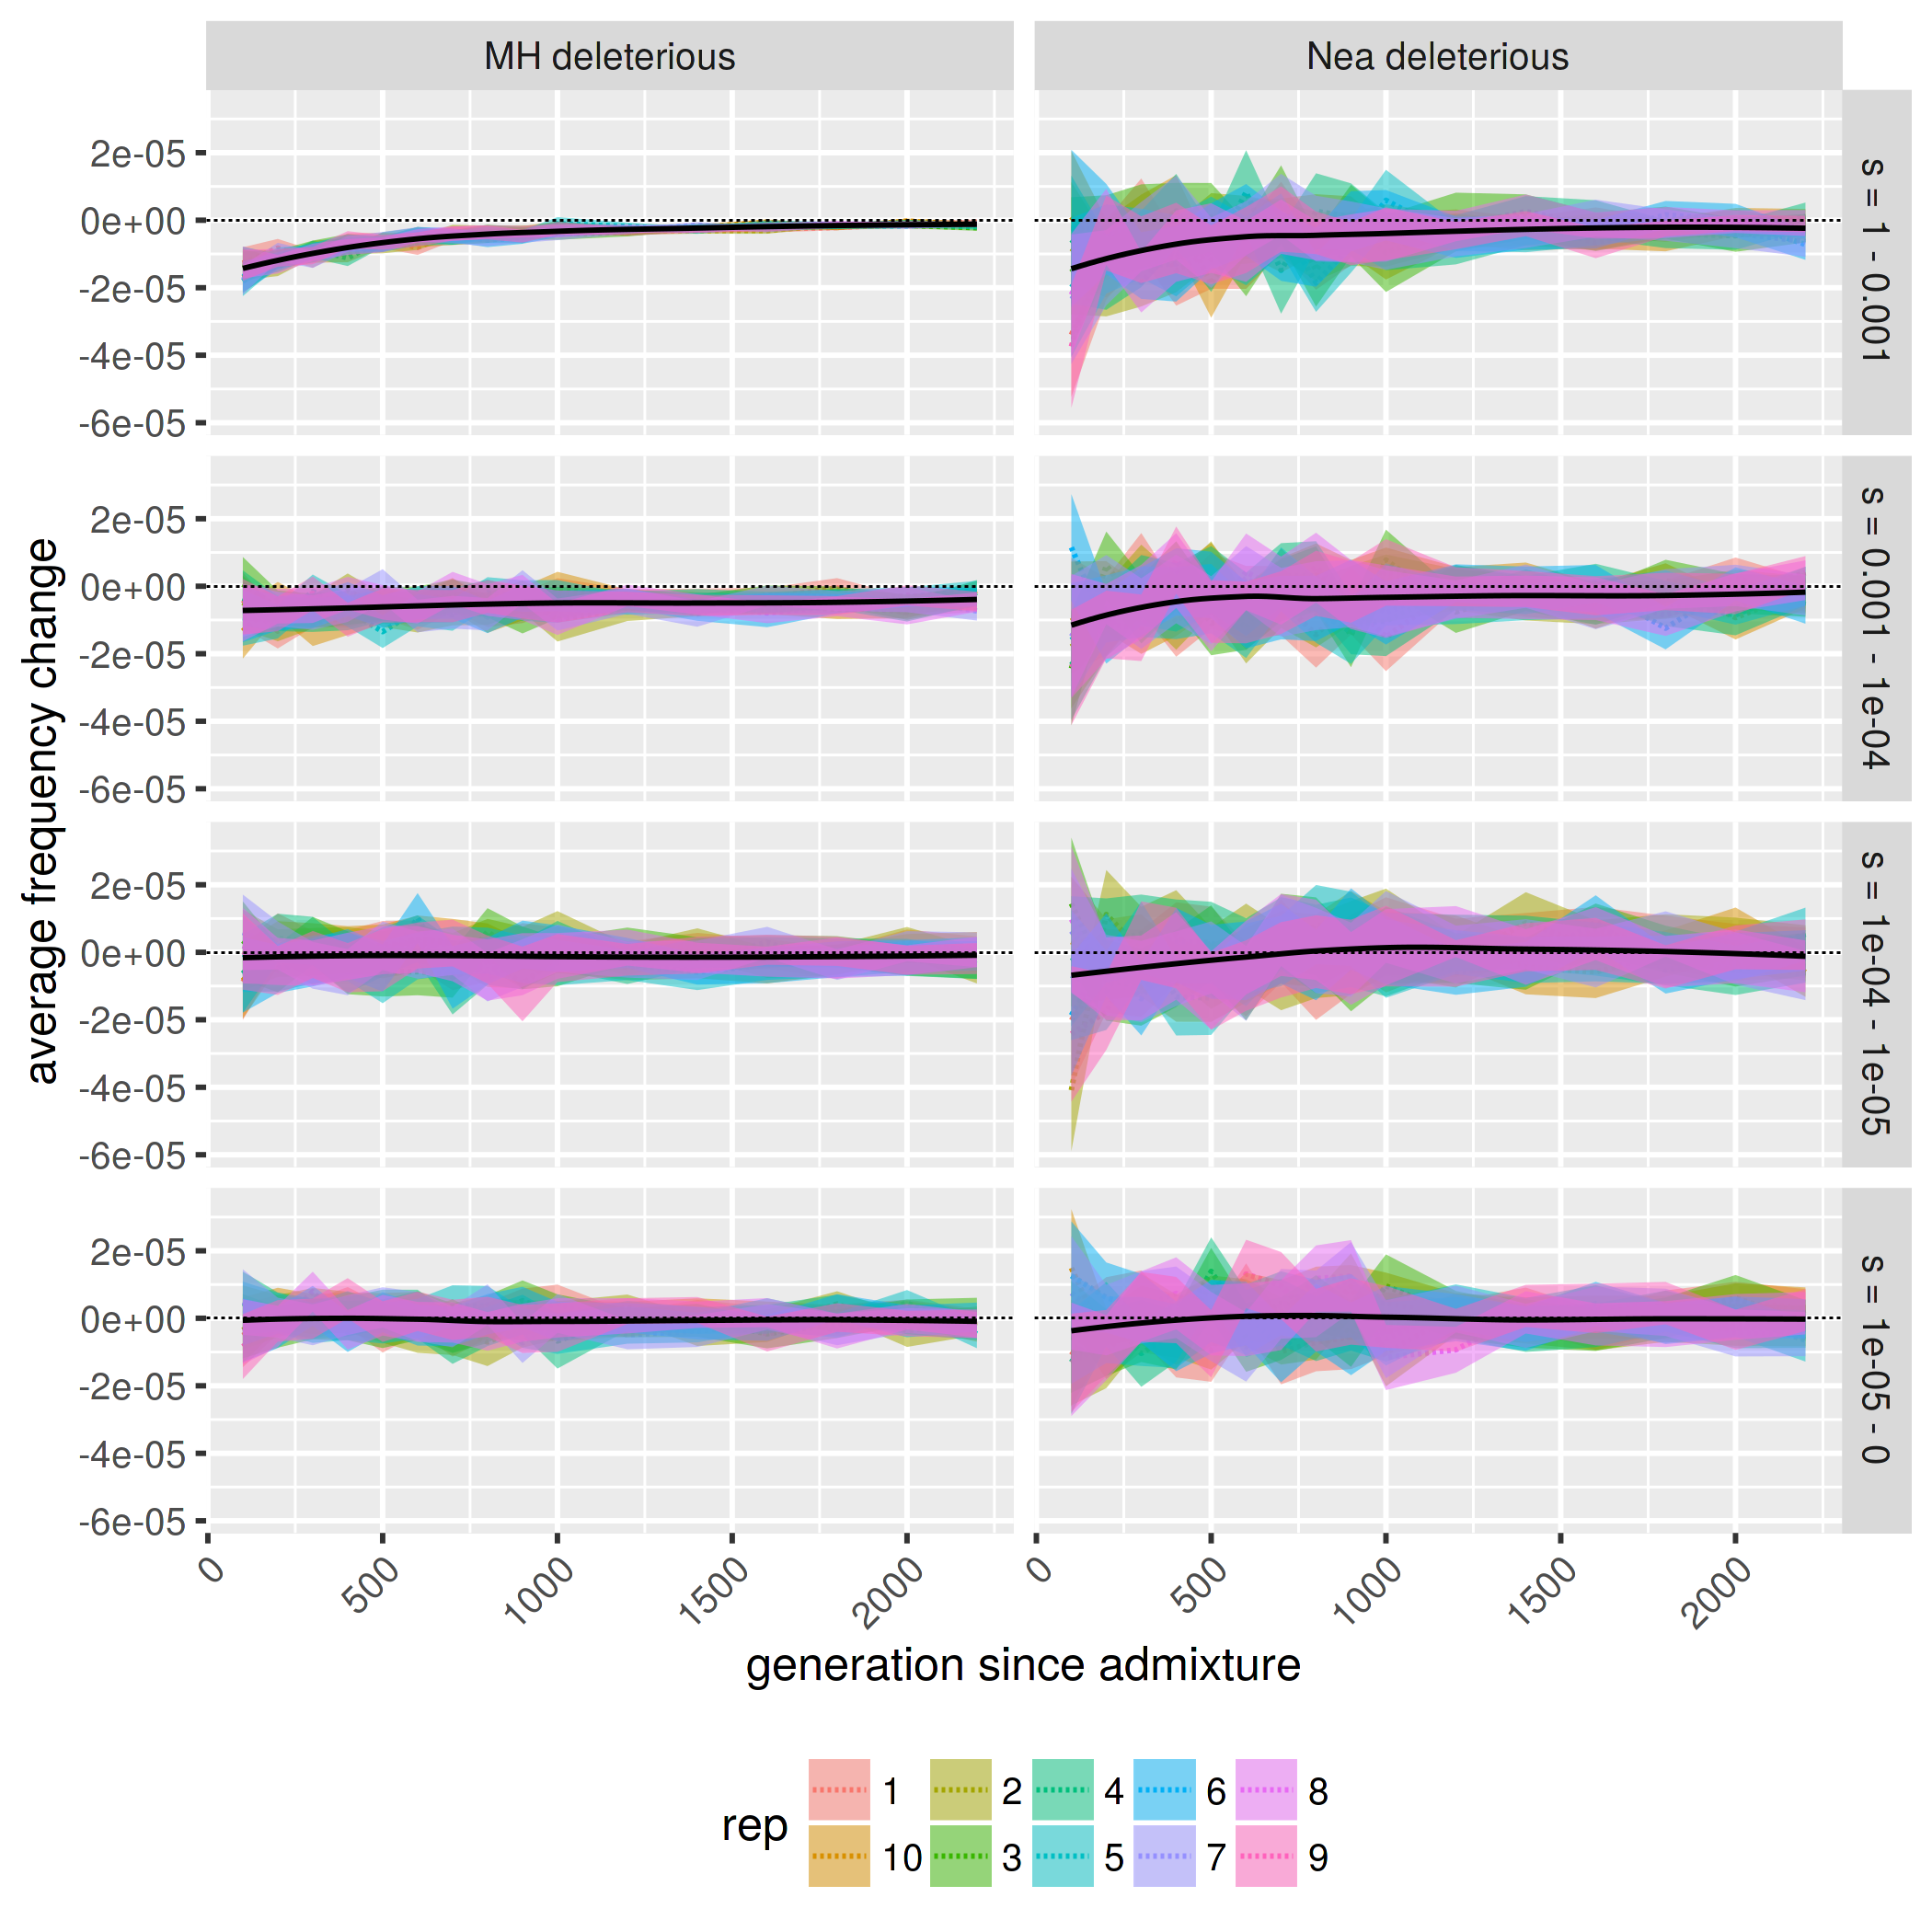

In [20]:
options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=300)

deltas %>% mutate(logS_bin=cut(logS,
                               breaks=s_breaks,
                               labels=s_bins)) %>%
    replace_na(list(logS_bin="s = 1e-05 - 0")) %>% 
    mutate(logS_bin=factor(logS_bin, levels=rev(s_bins))) %>% 
group_by(g, mut_type, rep, logS_bin) %>%    
    summarise(avg_delta=mean(delta_f), sd_delta=sd(delta_f), n_delta=n()) %>%
    mutate(se_delta=sd_delta / sqrt(n_delta),
           lower_ci=avg_delta - qt(1 - (0.05 / 2), n_delta - 1) * se_delta,
           upper_ci=avg_delta + qt(1 - (0.05 / 2), n_delta - 1) * se_delta) %>% 
filter(g >= 100) %>% 
filter(mut_type %in% c("MH_del", "Nea_del")) %>% 
ungroup %>% 
mutate(mut_type=str_replace(mut_type, "MH_del", "MH deleterious") %>% str_replace("Nea_del", "Nea deleterious")) %>% 
ggplot(aes(g, avg_delta)) +
    geom_line(aes(color=rep), linetype=2) +
    geom_ribbon(aes(g, ymin=lower_ci, ymax=upper_ci, fill=rep), alpha=1/2) +
    geom_smooth(color="black", alpha=1/2, se=FALSE, size=0.5) + 
    geom_hline(yintercept=0, linetype=2, size=0.25) + facet_grid(logS_bin ~ mut_type) +
    xlab("generation since admixture") + ylab("average frequency change") +
    theme(legend.position="bottom", text=element_text(size=12), axis.text.x = element_text(hjust=1, angle=45))

### SFS vs _s_ of deleterious mutations

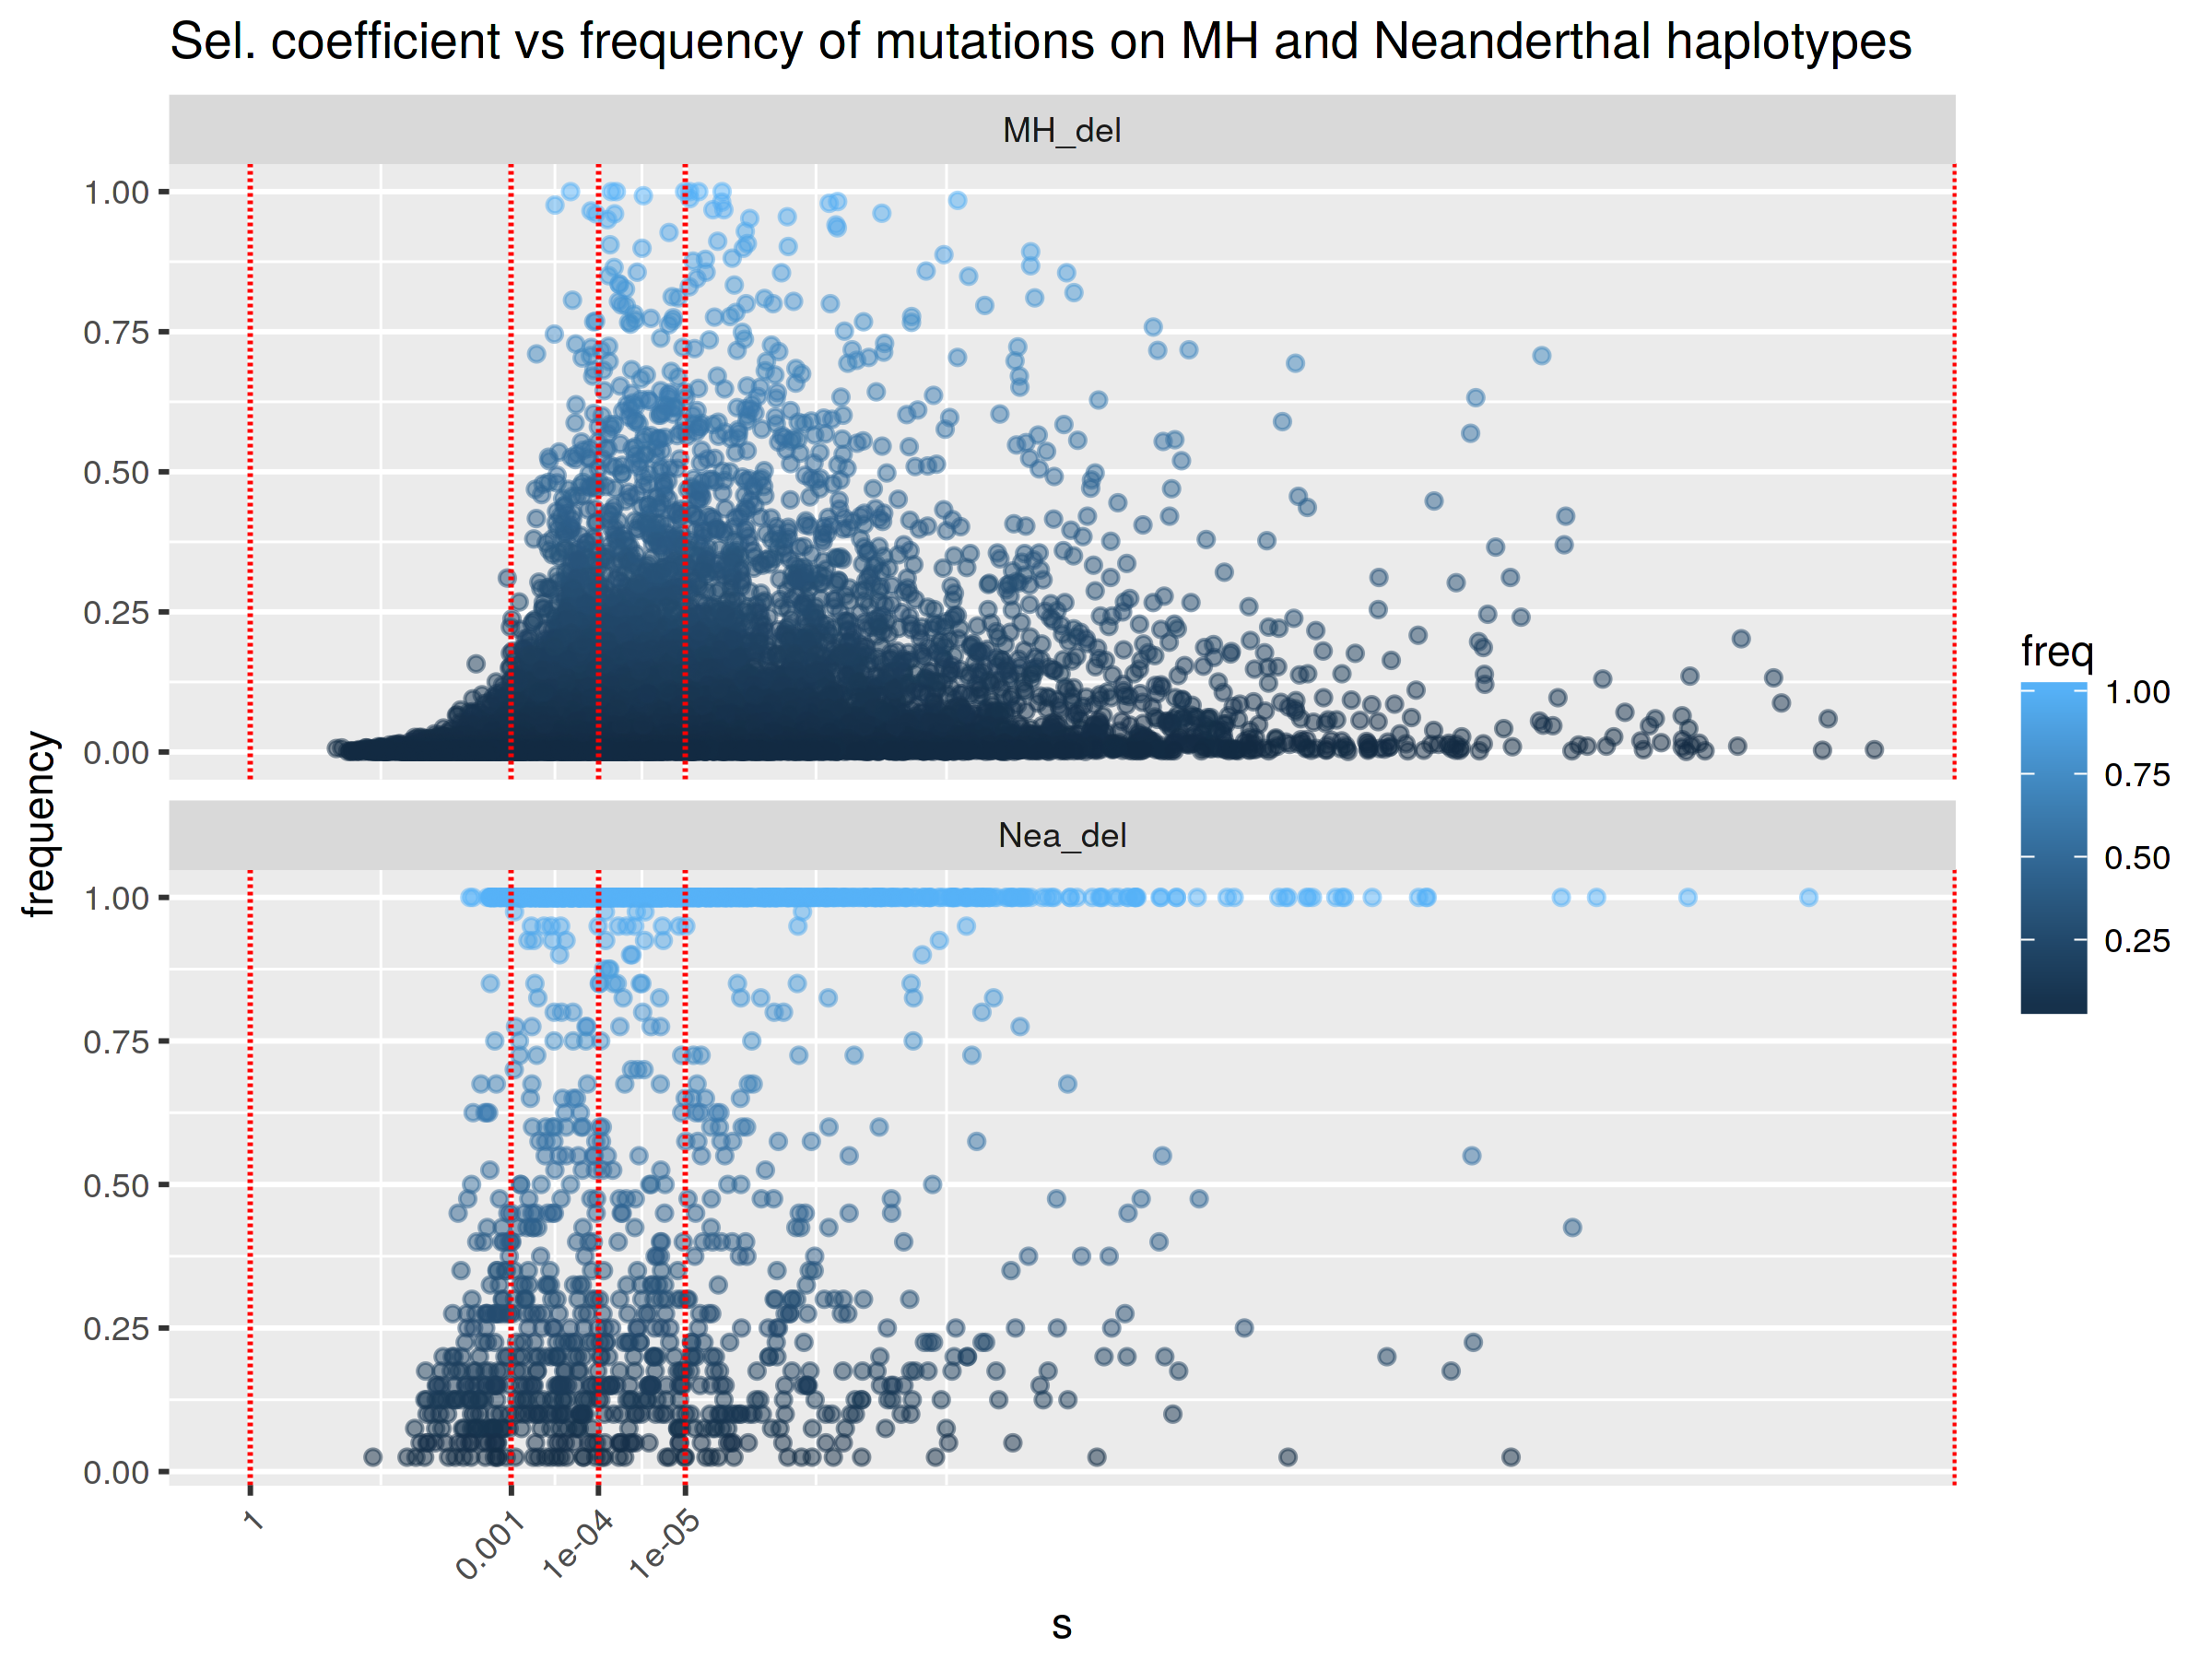

In [21]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res=300)

bind_rows(nea_muts, mh_muts) %>% filter(gen == 1, rep == 2) %>% 
group_by(mut_type) %>%
mutate(freq=freq / max(freq)) %>%
ggplot(aes(log10(-S), freq, color=freq, group=mut_type)) +
    geom_point(alpha=1/2) +
    labs(title="Sel. coefficient vs frequency of mutations on MH and Neanderthal haplotypes") +
    xlab("log10(selection coefficient)") + ylab("frequency") +
    facet_wrap(~ mut_type, scales="free_y", ncol=1) +
    geom_vline(xintercept=s_breaks, linetype=2, color="red") +
    scale_x_reverse(name="s", breaks=s_breaks[-length(s_breaks)], labels=s_labels[-length(s_labels)]) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

Warning message in `[<-.factor`(`*tmp*`, !is_complete(data[[var]]), value = "1e-05 - 0"):
“invalid factor level, NA generated”

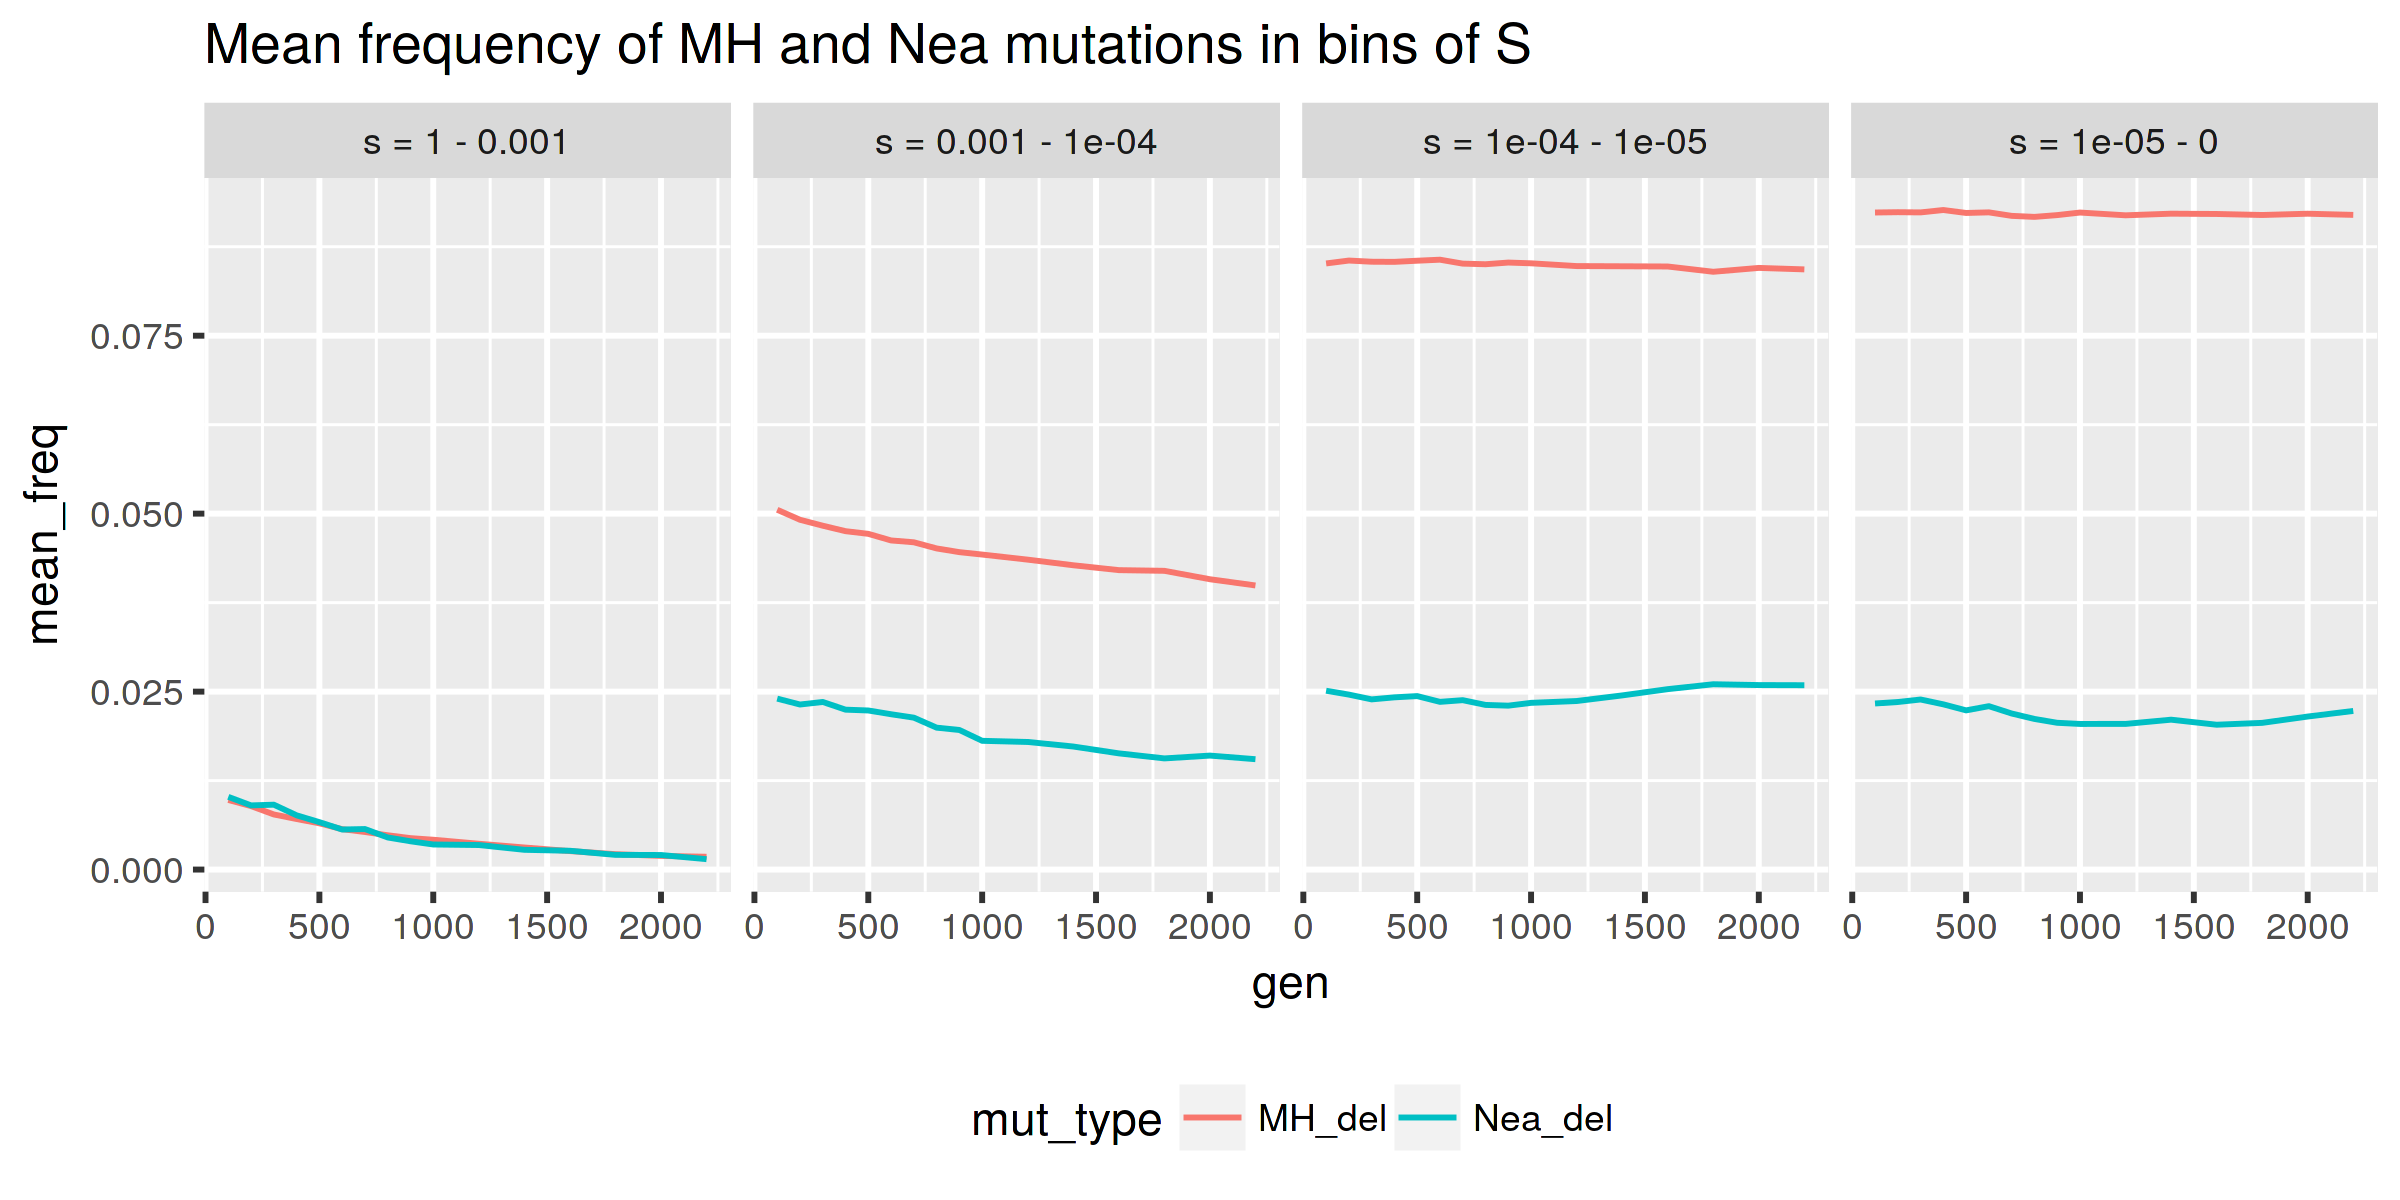

In [23]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=300)

s_breaks <- c(0, -3, -4, -5, -Inf)
s_labels <- as.character(10^s_breaks)
s_bins <- rev(paste0("s = ", s_labels[-length(s_labels)], paste0(" - ", s_labels[-1])))

bind_rows(nea_muts, mh_muts) %>%
    mutate(logS=log10(-S)) %>% 
    mutate(logS_bin=cut(logS, breaks=s_breaks, labels=s_bins)) %>%
    replace_na(list(logS_bin="1e-05 - 0")) %>% 
    mutate(logS_bin=factor(logS_bin, levels=rev(s_bins))) %>%
    group_by(mut_type, gen, logS_bin) %>% filter(rep == 1) %>% 
    summarise(mean_freq=mean(freq)) %>% filter(gen >= 100) %>% 
ggplot(aes(gen, mean_freq, color=mut_type)) + geom_line() + facet_grid(. ~ logS_bin) +
    ggtitle("Mean frequency of MH and Nea mutations in bins of S") +
    theme(legend.position="bottom")

Do both of these curves have really the same slopes?

<font color="red"><h4>Main point</h4>
Does the trajectory of N ancestry (on neutral markers) level off because the sites become unlinked from the nearby deleterious sequence or because the deleterious sequence simply stops being efficiently removed?</font>

In [35]:
save.image("../data/RData/selection_efficacy_protein_coding.RData")

Warning message in rq.fit.br(wx, wy, tau = tau, ...):
“Solution may be nonunique”

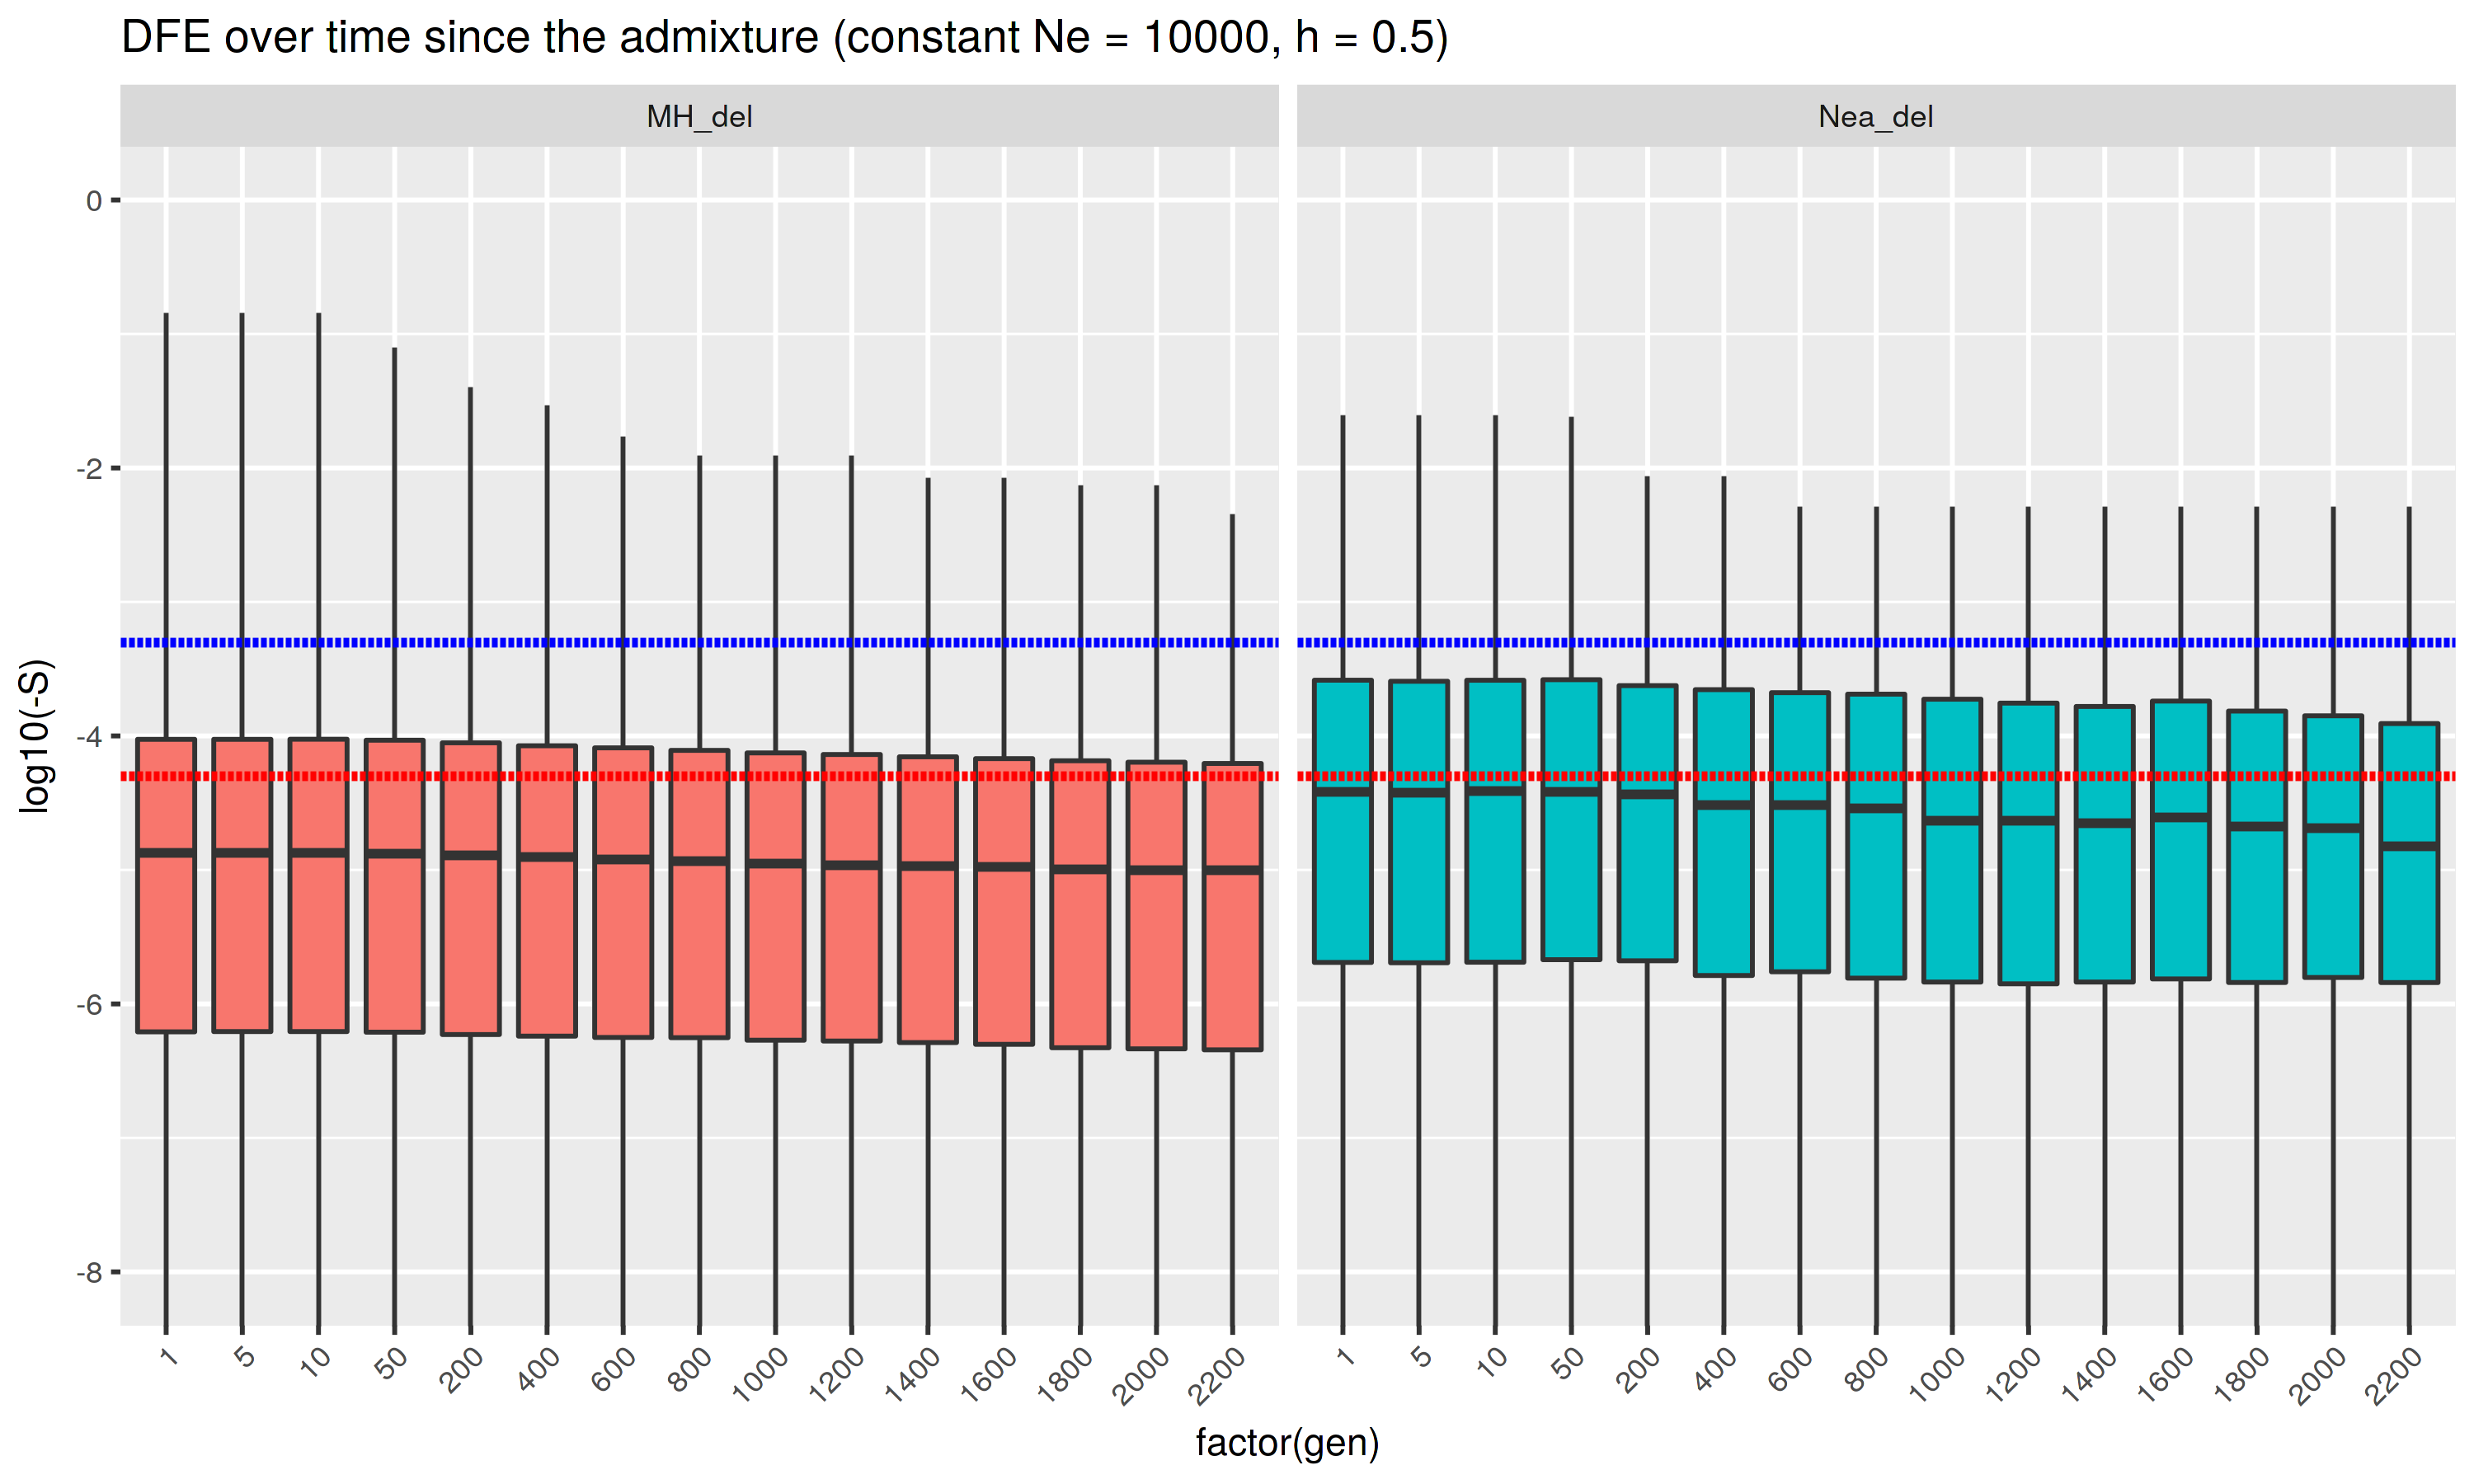

In [24]:
options(repr.plot.width=10, repr.plot.height=6)

# DFE plots
bind_rows(nea_muts, mh_muts) %>%
filter(rep == 1, freq > 0) %>% 
filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), fill=mut_type, weight=freq)) +
  geom_boxplot() +
  facet_wrap(~ mut_type) +
  coord_cartesian(y=c(0, -8)) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=log10(1/(2*10000)), linetype=5, size=1, color="red") +
  geom_hline(yintercept=log10(1/(2*1000)), linetype=5, size=1, color="blue") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")

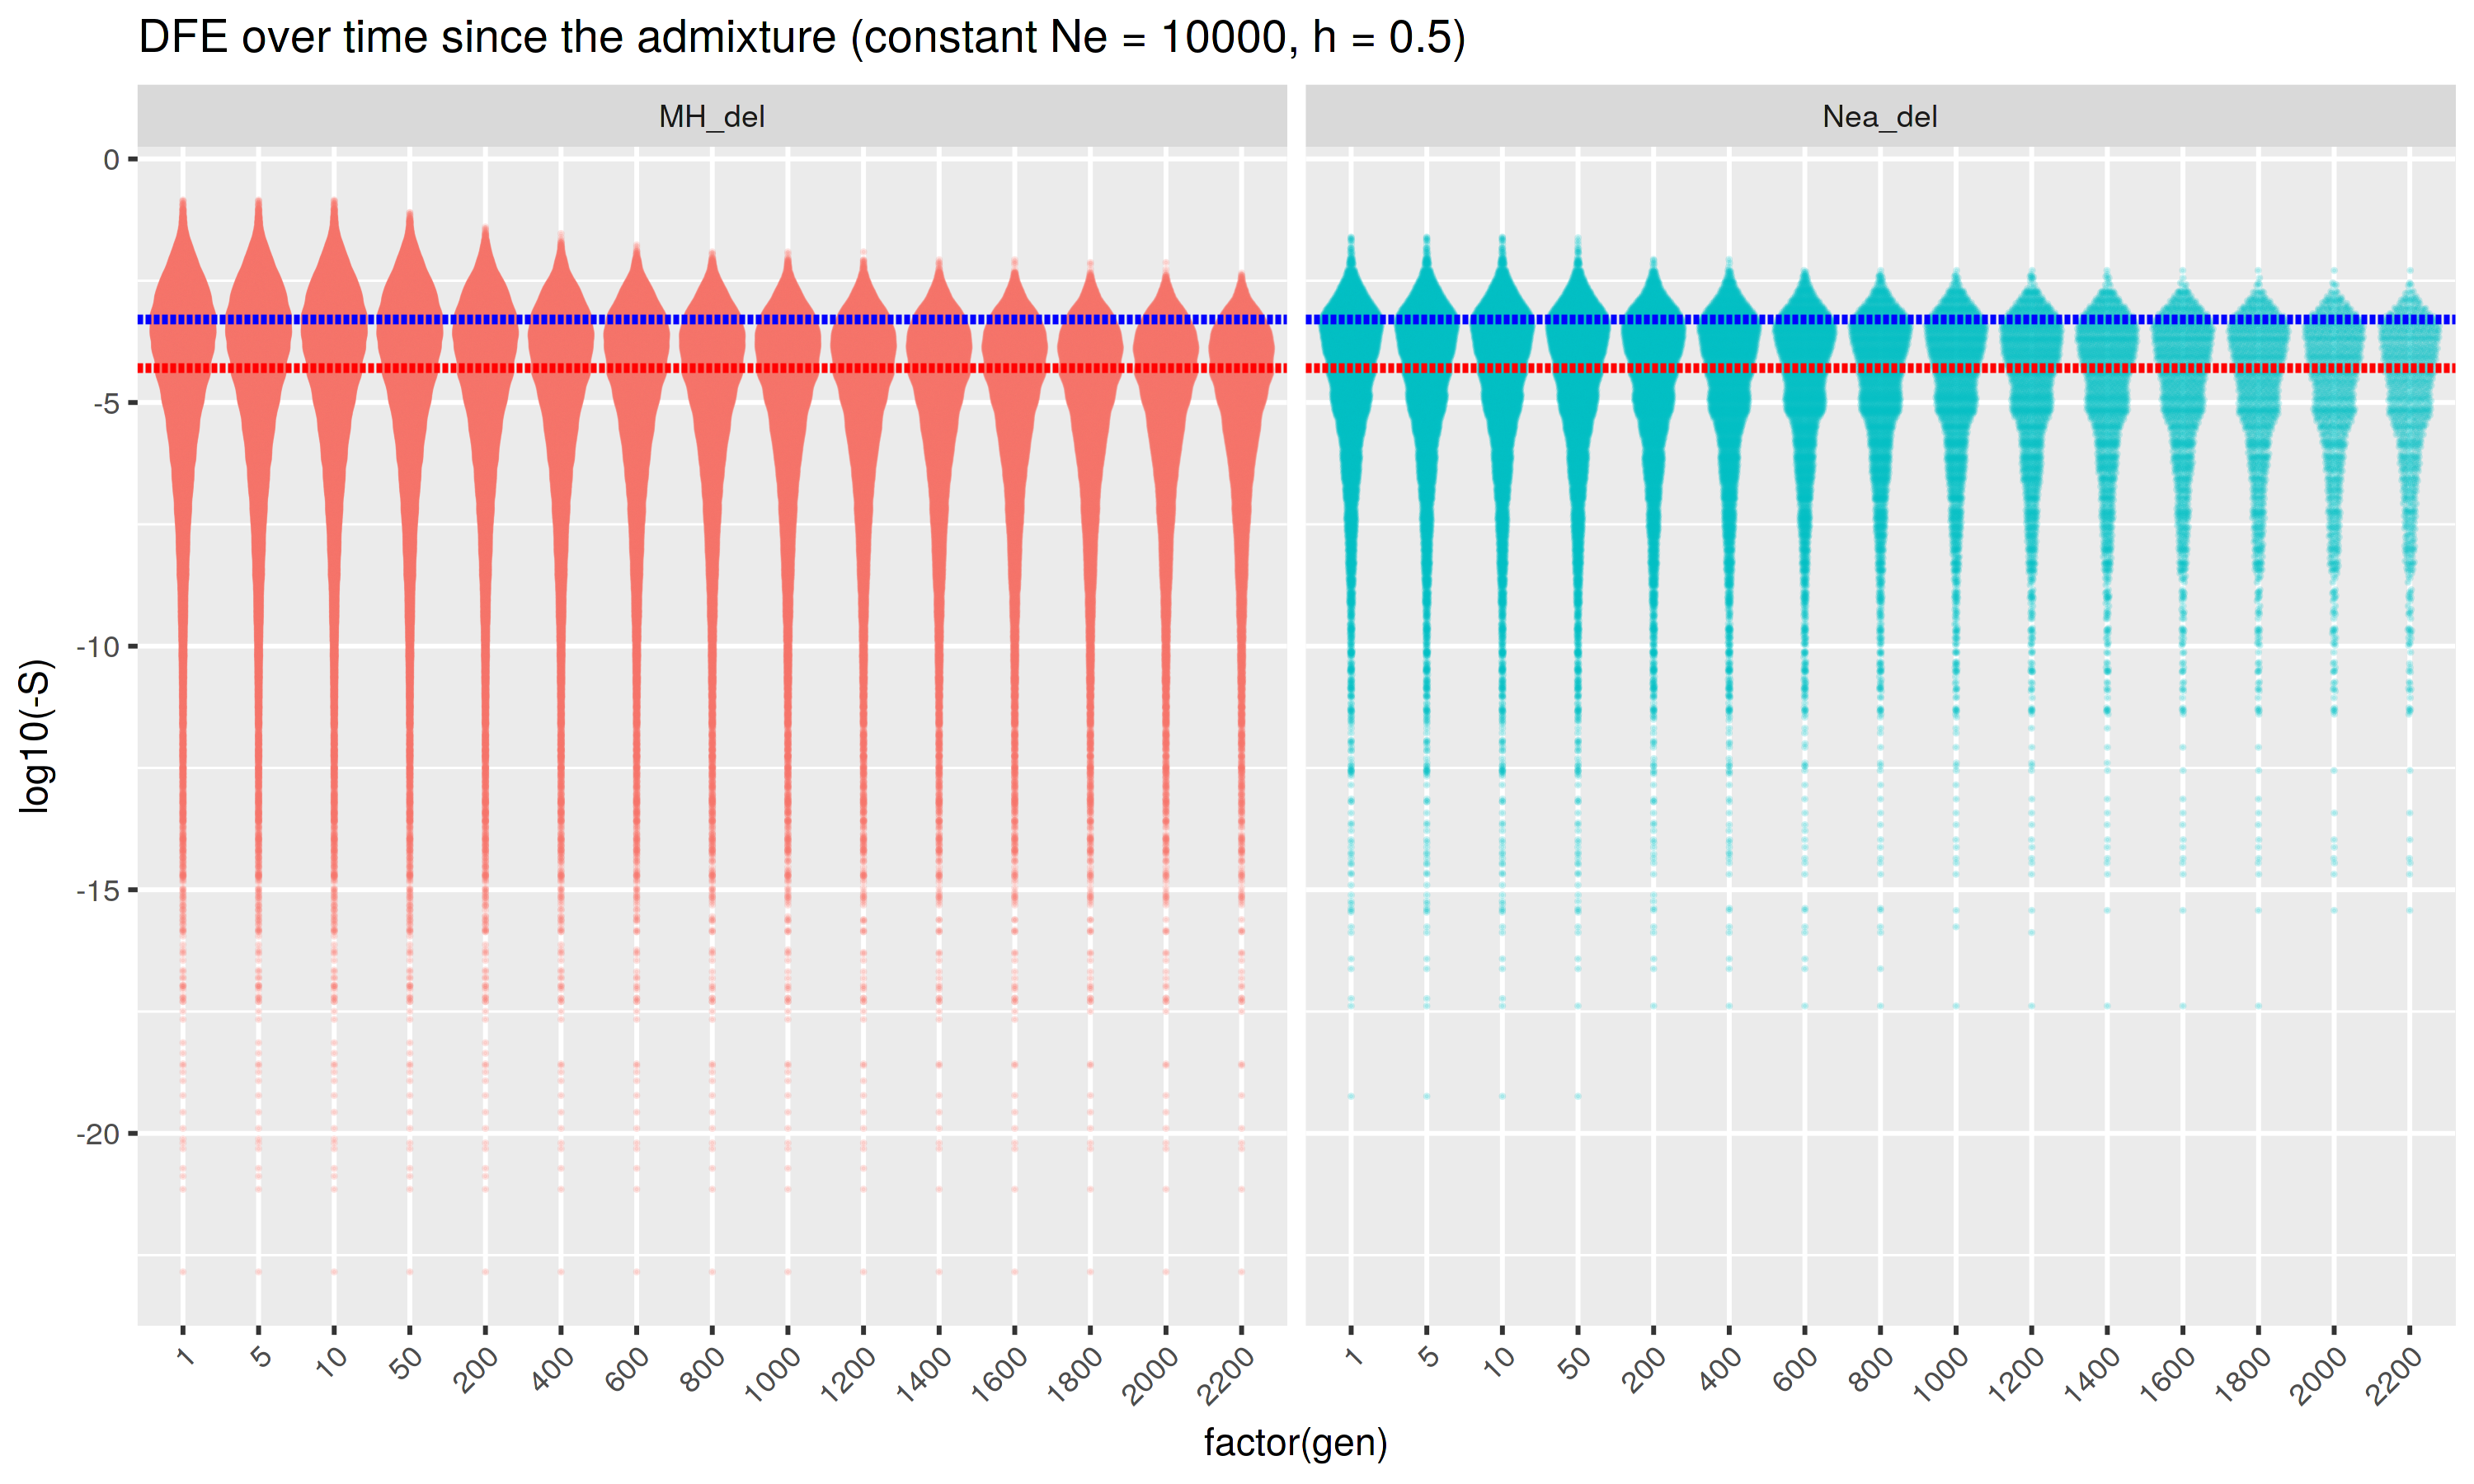

In [25]:
options(repr.plot.width=10, repr.plot.height=6)

# DFE plots
bind_rows(nea_muts, mh_muts) %>%
filter(rep == 1, freq > 0) %>%
filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), color=mut_type, weight=freq)) +
  geom_quasirandom(alpha=1/5, size=0.1) +
  facet_wrap(~ mut_type) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=log10(1/(2*10000)), linetype=5, size=1, color="red") +
  geom_hline(yintercept=log10(1/(2*1000)), linetype=5, size=1, color="blue") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")



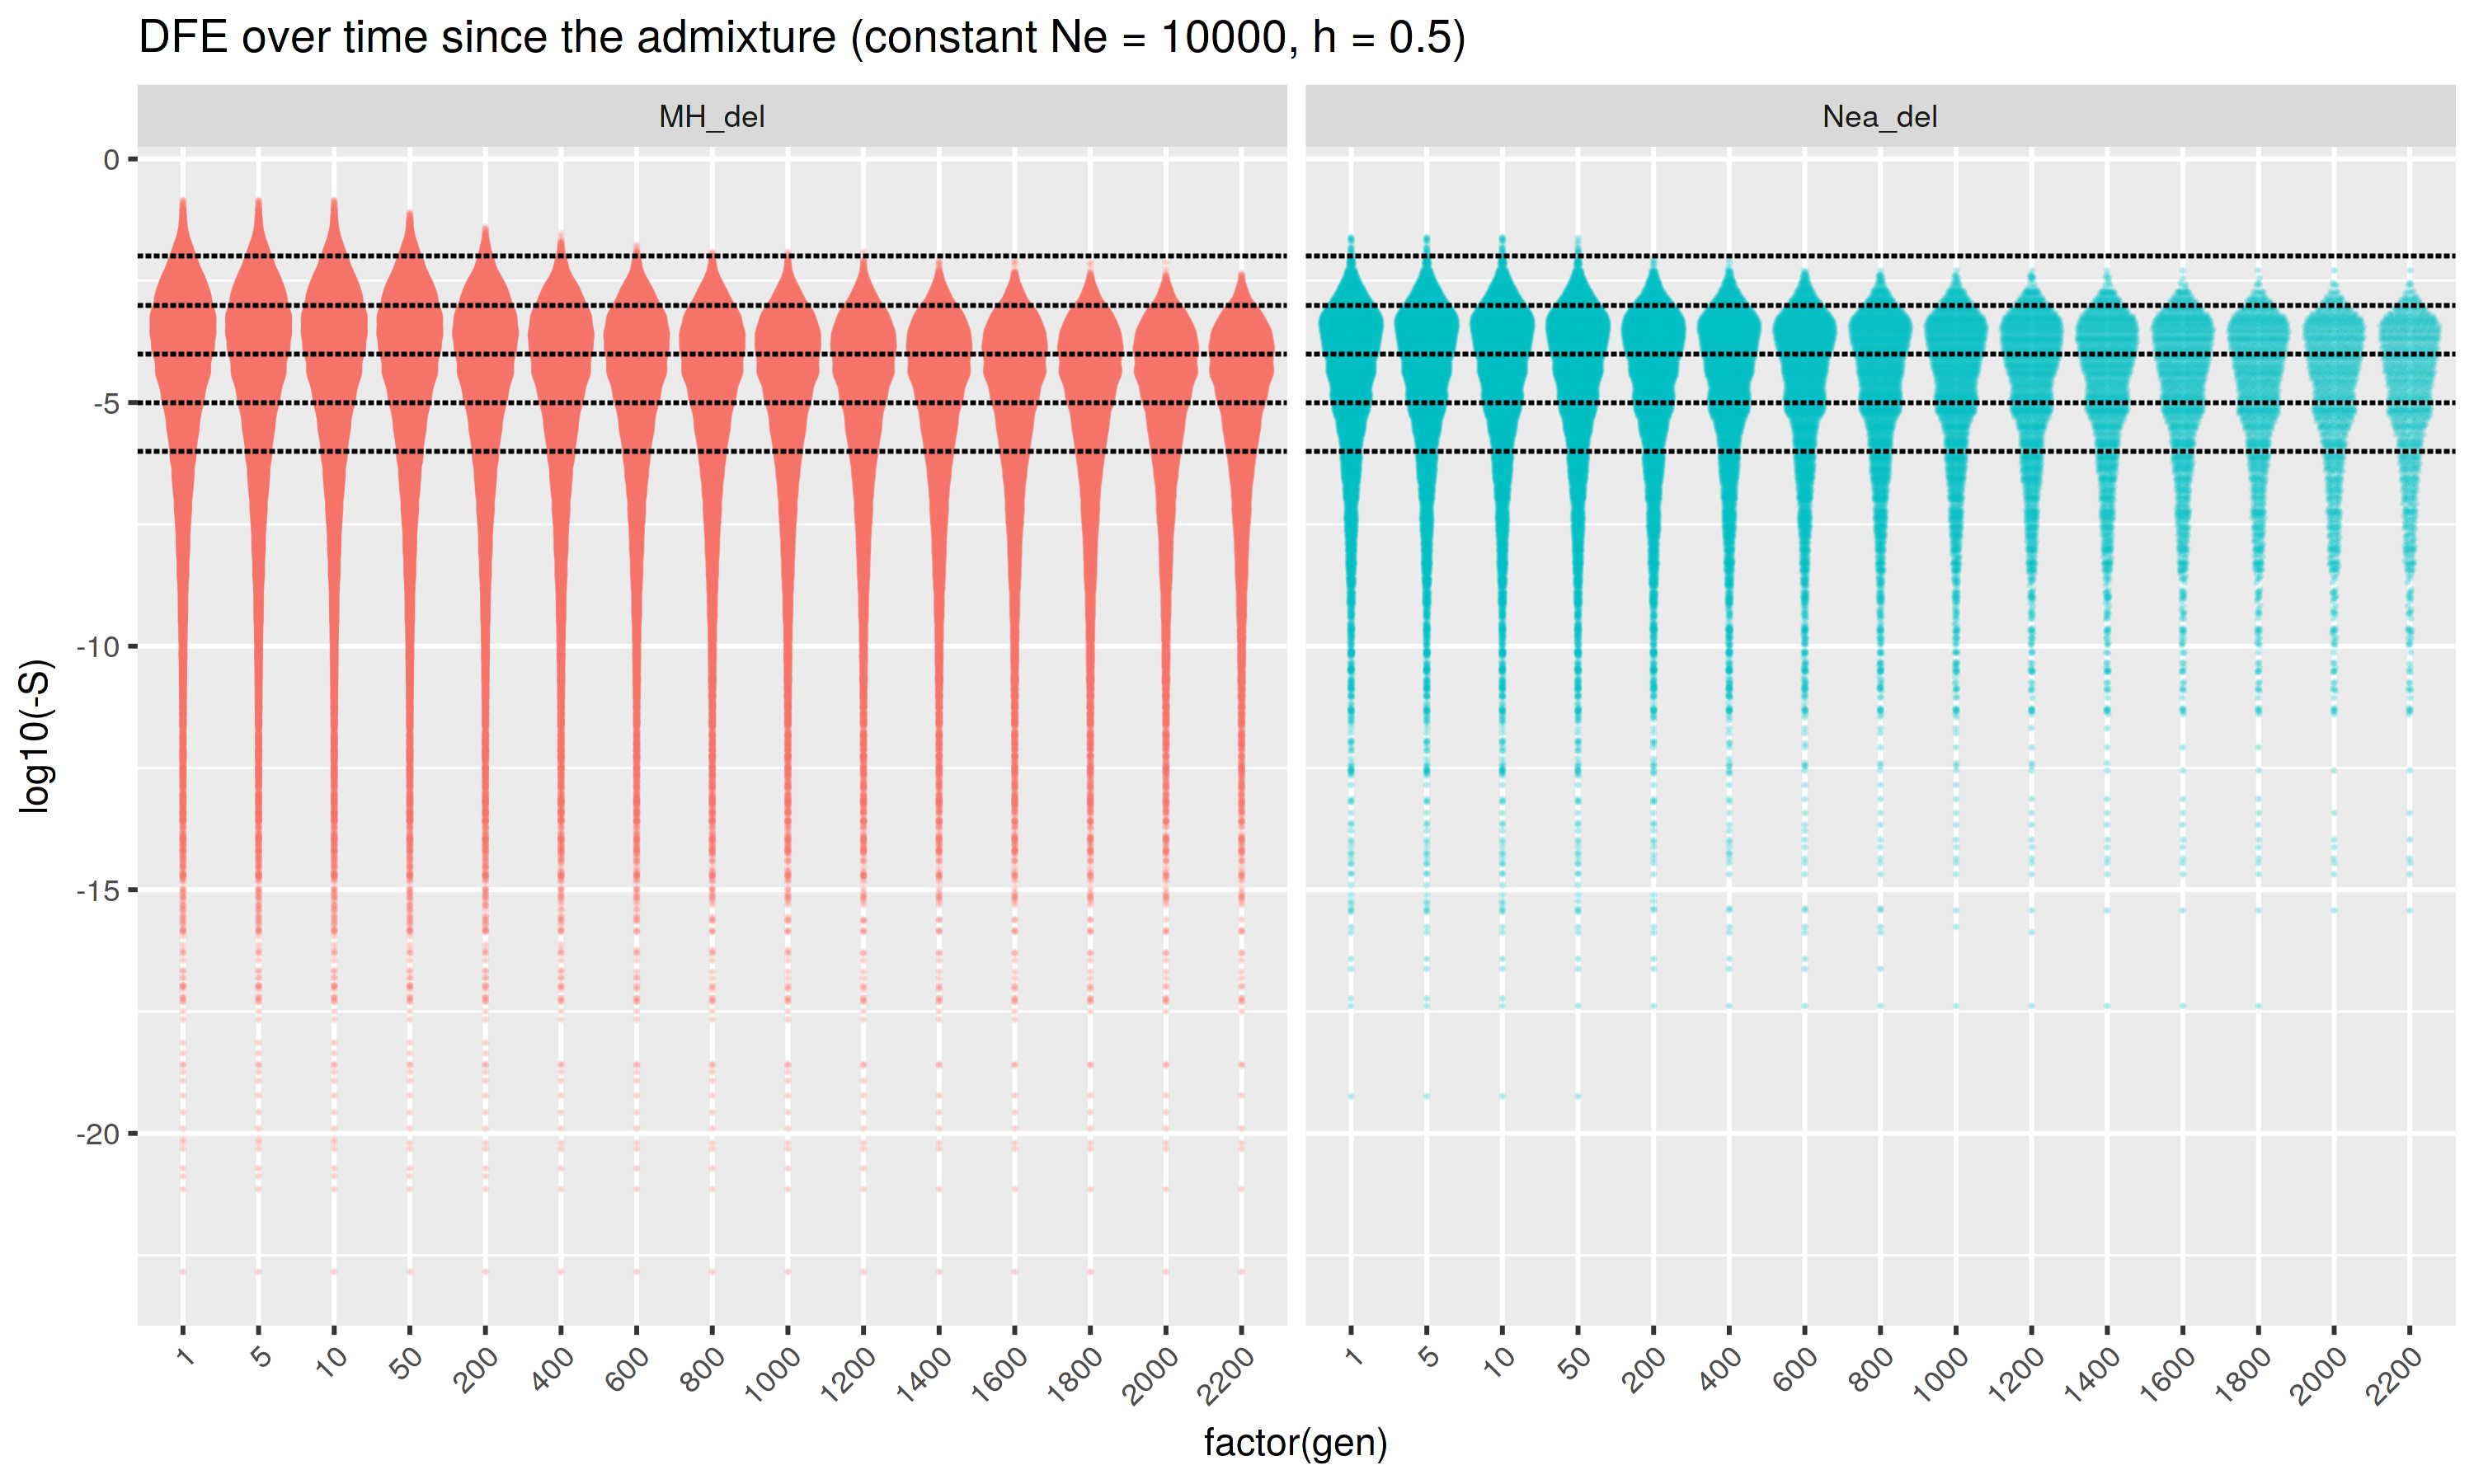

In [26]:
options(repr.plot.width=10, repr.plot.height=6)

# DFE plots
bind_rows(nea_muts, mh_muts) %>%
filter(rep == 1, freq > 0) %>%
filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), color=mut_type, weight=freq)) +
  geom_quasirandom(alpha=1/5, size=0.1) +
  facet_wrap(~ mut_type) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=c(-2, -3, -4, -5, -6), linetype=5, size=0.5, color="black") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")